In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.utils.data as data
from torch.autograd import Variable
from torchvision import datasets,transforms
import numpy as np 
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
device = torch.device("cuda: 0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [3]:
DATA_DIR = "data/trainingSet"

In [4]:
PROCESS_DATA = 1
TRAINING_DATA = 1

In [5]:
IMG_SIZE = 64
BATCH_SIZE = 64
LATENT_SIZE = 100

In [6]:
data_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [7]:
if PROCESS_DATA:
    dataset = datasets.ImageFolder(DATA_DIR, transform= data_transform)
    dataloader = data.DataLoader(dataset,batch_size=BATCH_SIZE, num_workers=4, shuffle=True)

In [8]:
#Show data size
print(len(dataset))

17611


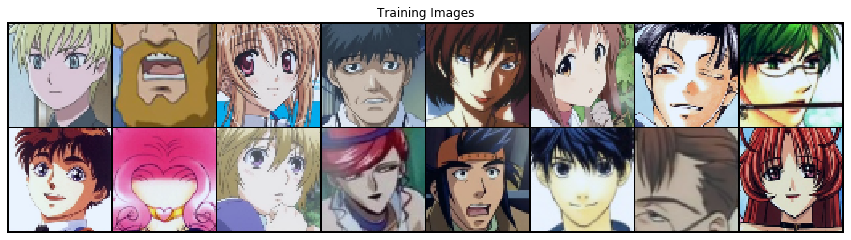

In [9]:
#Visualize some training data
def visualize_data(dataloader, NUM_PIC=16):
    a = np.random.randint(BATCH_SIZE-NUM_PIC)
    fig = plt.figure(figsize=(15,15))
    img = next(iter(dataloader))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(torchvision.utils.make_grid(img[0][a:a+NUM_PIC],padding=1, normalize=True),(1,2,0)))
    plt.show()

visualize_data(dataloader)

In [10]:
#Make random latent noise vector
def random_noise(size):
    noise = torch.randn(size, LATENT_SIZE, 1 , 1)
    return Variable(noise).to(device)

In [11]:
#Generate truth or false label
def generate_label(size,label):
    if label:
        data = torch.ones(size,1) - 0.1 #Smooth label one-side
    else:
        data = torch.zeros(size,1)
    return Variable(data).view(-1).to(device)

In [12]:
#Inititate weights for Generator and Discriminator with mean = 0.02, standard deviation = 1
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [13]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100,128*8,4,1,0),
            nn.BatchNorm2d(128*8),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*8,128*4,4,2,1),
            nn.BatchNorm2d(128*4),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*4,128*2,4,2,1),
            nn.BatchNorm2d(128*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(128*2,128,4,2,1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128,3,4,2,1),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.main(x)
        return x

In [14]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 128*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*2, 128*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*4, 128*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128*8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
#Train the discriminator
def train_discriminator(D, D_optimizer, error, real_data, fake_data):
    batch_size = real_data.size(0)
    D_optimizer.zero_grad()
    
    #Training on all real data
    real_data = real_data.to(device)
    predict_real = D(real_data).view(-1)
    real_label = generate_label(batch_size, 1)
    loss_real = error(predict_real,real_label)
    loss_real.backward()
    
    
    #Training on all fake data
    fake_data = fake_data.to(device)
    predict_fake = D(fake_data).view(-1)
    fake_label = generate_label(batch_size, 0)
    loss_fake = error(predict_fake, fake_label)
    loss_fake.backward()
    
    D_x = predict_real.mean().item()
    D_g_z1 = predict_fake.mean().item()
    
    D_optimizer.step()
    
    return loss_real.data+loss_fake.data, D_x, D_g_z1
    

In [16]:
#Train the generator
def train_generator(D, G_optimizer, error, fake_data):
    batch_size = fake_data.size(0)
    G_optimizer.zero_grad()
    fake_data = fake_data.to(device)
    predict = D(fake_data).view(-1)
    real_label = generate_label(batch_size, 1)
    loss = error(predict, real_label)
    loss.backward()
    G_optimizer.step()
    D_g_z2 = predict.mean().item()
    return loss.data, D_g_z2

In [17]:
#Generate some samples
def generate_samples(G, noise):
    G.eval()
    with torch.no_grad():
        fig = plt.figure(figsize=(15,10))
        generated = G(noise).view(-1,3,IMG_SIZE,IMG_SIZE).data.cpu()
        img = np.transpose(torchvision.utils.make_grid(generated[:],padding =1, normalize=True),(1,2,0))
        plt.imshow(img)
        plt.axis("off")
        plt.title("Generated Images")
        plt.show()
    G.train()

In [18]:
#Generate fixed test noise
test_noise = random_noise(16)

In [19]:
#Start training process
def train(D, G, D_optimizer, G_optimizer, error, dataloader):
    EPOCHS = 51
    D_loss_list = []
    G_loss_list = []
    print("Start Training.....")
    for epoch in range(EPOCHS):
        for i, (real_batch,_) in enumerate(dataloader):
            #First train the Discriminator
            batch_size = real_batch.size(0)
            real_data = Variable(real_batch.view(-1,3,IMG_SIZE,IMG_SIZE))
            fake_data = G(random_noise(batch_size)).detach()
            D_loss, D_x, D_g_z1 = train_discriminator(D, D_optimizer, error, real_data, fake_data)
            
            #Then train the Generator
            data = G(random_noise(batch_size))
            G_loss, D_g_z2 = train_generator(D, G_optimizer, error, data)
            
            D_loss_list.append(D_loss)
            G_loss_list.append(G_loss)
            
            if i%100==0:
                print("Epoch: ({}/{}), Batch: ({}/{}), D_Loss: {:.4f}, G_Loss: {:.4f}, D(x): {:.4f}, G(D(z)): {:.4f} / {:.4f}".format(epoch+1,EPOCHS,i,len(dataloader),D_loss,G_loss,D_x, D_g_z1,D_g_z2))
        torch.save(G.state_dict(), "model/generator2.pth")
        torch.save(D.state_dict(), "model/discriminator2.pth")
        if epoch%5==0:
            generate_samples(G, test_noise)
    print("Training Completed!")
    return G, D_loss_list, G_loss_list

Start Training.....
Epoch: (1/51), Batch: (0/276), D_Loss: 2.4380, G_Loss: 1.0473, D(x): 0.2181, G(D(z)): 0.2193 / 0.4308
Epoch: (1/51), Batch: (100/276), D_Loss: 0.3918, G_Loss: 48.3498, D(x): 0.9296, G(D(z)): 0.0000 / 0.0000
Epoch: (1/51), Batch: (200/276), D_Loss: 0.3593, G_Loss: 43.2817, D(x): 0.8953, G(D(z)): 0.0000 / 0.0000


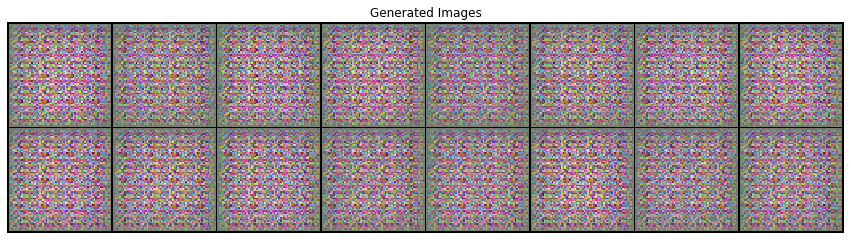

Epoch: (2/51), Batch: (0/276), D_Loss: 0.3411, G_Loss: 41.7143, D(x): 0.9281, G(D(z)): 0.0000 / 0.0000
Epoch: (2/51), Batch: (100/276), D_Loss: 0.3430, G_Loss: 39.1198, D(x): 0.9149, G(D(z)): 0.0000 / 0.0000
Epoch: (2/51), Batch: (200/276), D_Loss: 0.3316, G_Loss: 36.6851, D(x): 0.9119, G(D(z)): 0.0000 / 0.0000
Epoch: (3/51), Batch: (0/276), D_Loss: 0.3662, G_Loss: 34.7156, D(x): 0.9391, G(D(z)): 0.0000 / 0.0000
Epoch: (3/51), Batch: (100/276), D_Loss: 0.8568, G_Loss: 3.9678, D(x): 0.8129, G(D(z)): 0.2307 / 0.0241
Epoch: (3/51), Batch: (200/276), D_Loss: 0.8296, G_Loss: 4.8936, D(x): 0.8316, G(D(z)): 0.2909 / 0.0080
Epoch: (4/51), Batch: (0/276), D_Loss: 1.0389, G_Loss: 4.5650, D(x): 0.8492, G(D(z)): 0.3577 / 0.0101
Epoch: (4/51), Batch: (100/276), D_Loss: 0.7776, G_Loss: 3.5514, D(x): 0.7823, G(D(z)): 0.2057 / 0.0270
Epoch: (4/51), Batch: (200/276), D_Loss: 1.5282, G_Loss: 6.2870, D(x): 0.7825, G(D(z)): 0.5553 / 0.0097
Epoch: (5/51), Batch: (0/276), D_Loss: 1.1075, G_Loss: 1.3828, D(x

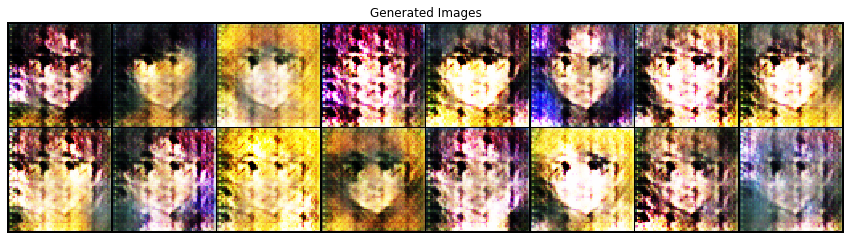

Epoch: (7/51), Batch: (0/276), D_Loss: 1.0200, G_Loss: 2.3976, D(x): 0.5822, G(D(z)): 0.2040 / 0.1079
Epoch: (7/51), Batch: (100/276), D_Loss: 1.3389, G_Loss: 5.7410, D(x): 0.8214, G(D(z)): 0.5290 / 0.0059
Epoch: (7/51), Batch: (200/276), D_Loss: 0.7886, G_Loss: 3.6412, D(x): 0.6989, G(D(z)): 0.2069 / 0.0318
Epoch: (8/51), Batch: (0/276), D_Loss: 0.8565, G_Loss: 2.2905, D(x): 0.5927, G(D(z)): 0.0667 / 0.1279
Epoch: (8/51), Batch: (100/276), D_Loss: 0.8089, G_Loss: 3.3137, D(x): 0.6326, G(D(z)): 0.0736 / 0.0445
Epoch: (8/51), Batch: (200/276), D_Loss: 0.6688, G_Loss: 3.8399, D(x): 0.7257, G(D(z)): 0.1095 / 0.0232
Epoch: (9/51), Batch: (0/276), D_Loss: 1.2550, G_Loss: 5.8432, D(x): 0.8753, G(D(z)): 0.4887 / 0.0042
Epoch: (9/51), Batch: (100/276), D_Loss: 0.7196, G_Loss: 3.1663, D(x): 0.7417, G(D(z)): 0.1761 / 0.0464
Epoch: (9/51), Batch: (200/276), D_Loss: 1.2220, G_Loss: 6.7691, D(x): 0.9339, G(D(z)): 0.4869 / 0.0034
Epoch: (10/51), Batch: (0/276), D_Loss: 2.6394, G_Loss: 7.8210, D(x): 

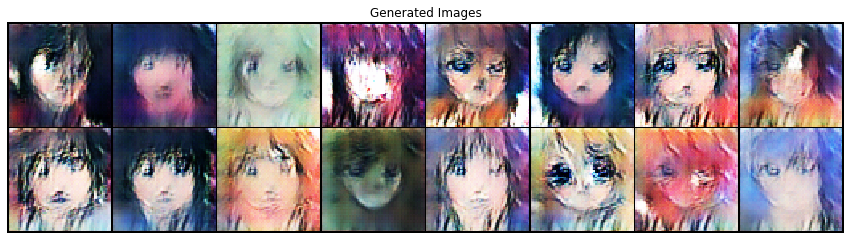

Epoch: (12/51), Batch: (0/276), D_Loss: 0.7634, G_Loss: 3.4197, D(x): 0.7463, G(D(z)): 0.2042 / 0.0390
Epoch: (12/51), Batch: (100/276), D_Loss: 0.5943, G_Loss: 2.0426, D(x): 0.7413, G(D(z)): 0.1116 / 0.1556
Epoch: (12/51), Batch: (200/276), D_Loss: 0.6491, G_Loss: 4.9952, D(x): 0.8227, G(D(z)): 0.1882 / 0.0088
Epoch: (13/51), Batch: (0/276), D_Loss: 0.6119, G_Loss: 4.7136, D(x): 0.7907, G(D(z)): 0.1111 / 0.0114
Epoch: (13/51), Batch: (100/276), D_Loss: 0.5515, G_Loss: 2.8856, D(x): 0.8728, G(D(z)): 0.0966 / 0.0664
Epoch: (13/51), Batch: (200/276), D_Loss: 0.7410, G_Loss: 4.7734, D(x): 0.8358, G(D(z)): 0.2446 / 0.0118
Epoch: (14/51), Batch: (0/276), D_Loss: 0.6130, G_Loss: 4.5697, D(x): 0.6615, G(D(z)): 0.0177 / 0.0150
Epoch: (14/51), Batch: (100/276), D_Loss: 0.6550, G_Loss: 3.2851, D(x): 0.7129, G(D(z)): 0.1147 / 0.0443
Epoch: (14/51), Batch: (200/276), D_Loss: 0.6729, G_Loss: 2.9908, D(x): 0.6672, G(D(z)): 0.0526 / 0.0713
Epoch: (15/51), Batch: (0/276), D_Loss: 1.9040, G_Loss: 9.685

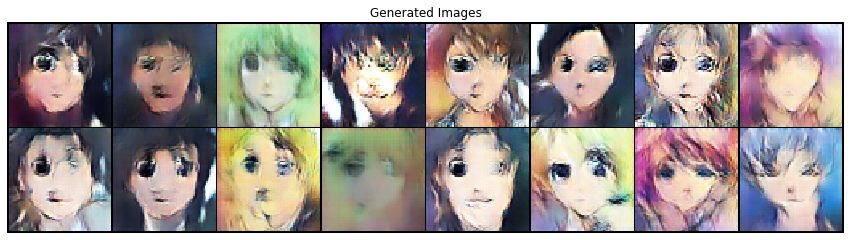

Epoch: (17/51), Batch: (0/276), D_Loss: 1.4342, G_Loss: 5.8523, D(x): 0.9895, G(D(z)): 0.5193 / 0.0028
Epoch: (17/51), Batch: (100/276), D_Loss: 0.6336, G_Loss: 4.3796, D(x): 0.8642, G(D(z)): 0.2038 / 0.0108
Epoch: (17/51), Batch: (200/276), D_Loss: 0.7639, G_Loss: 4.2946, D(x): 0.9552, G(D(z)): 0.2474 / 0.0199
Epoch: (18/51), Batch: (0/276), D_Loss: 0.5828, G_Loss: 5.1710, D(x): 0.8455, G(D(z)): 0.1078 / 0.0073
Epoch: (18/51), Batch: (100/276), D_Loss: 0.5351, G_Loss: 4.4527, D(x): 0.9218, G(D(z)): 0.1414 / 0.0112
Epoch: (18/51), Batch: (200/276), D_Loss: 0.7410, G_Loss: 2.5018, D(x): 0.5953, G(D(z)): 0.0549 / 0.1351
Epoch: (19/51), Batch: (0/276), D_Loss: 1.1182, G_Loss: 2.9615, D(x): 0.4782, G(D(z)): 0.0296 / 0.0992
Epoch: (19/51), Batch: (100/276), D_Loss: 1.0054, G_Loss: 3.6775, D(x): 0.9182, G(D(z)): 0.3625 / 0.0401
Epoch: (19/51), Batch: (200/276), D_Loss: 0.6150, G_Loss: 3.4135, D(x): 0.8034, G(D(z)): 0.1721 / 0.0380
Epoch: (20/51), Batch: (0/276), D_Loss: 1.1822, G_Loss: 5.396

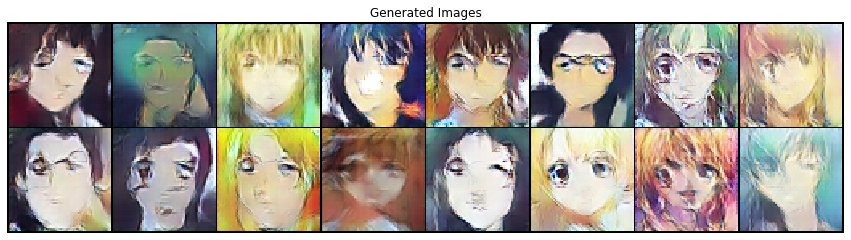

Epoch: (22/51), Batch: (0/276), D_Loss: 1.2063, G_Loss: 1.7720, D(x): 0.3603, G(D(z)): 0.0073 / 0.2523
Epoch: (22/51), Batch: (100/276), D_Loss: 0.6025, G_Loss: 2.0126, D(x): 0.6603, G(D(z)): 0.0588 / 0.1558
Epoch: (22/51), Batch: (200/276), D_Loss: 0.6244, G_Loss: 2.6908, D(x): 0.6834, G(D(z)): 0.0538 / 0.0736
Epoch: (23/51), Batch: (0/276), D_Loss: 0.5331, G_Loss: 2.3438, D(x): 0.8018, G(D(z)): 0.1067 / 0.1146
Epoch: (23/51), Batch: (100/276), D_Loss: 0.9463, G_Loss: 4.9046, D(x): 0.9318, G(D(z)): 0.3527 / 0.0122
Epoch: (23/51), Batch: (200/276), D_Loss: 0.6053, G_Loss: 2.8183, D(x): 0.7364, G(D(z)): 0.1108 / 0.0667
Epoch: (24/51), Batch: (0/276), D_Loss: 0.6752, G_Loss: 2.3869, D(x): 0.6301, G(D(z)): 0.0649 / 0.1144
Epoch: (24/51), Batch: (100/276), D_Loss: 0.6174, G_Loss: 2.1813, D(x): 0.7283, G(D(z)): 0.1130 / 0.1359
Epoch: (24/51), Batch: (200/276), D_Loss: 1.0803, G_Loss: 1.4366, D(x): 0.3926, G(D(z)): 0.0153 / 0.2725
Epoch: (25/51), Batch: (0/276), D_Loss: 0.7233, G_Loss: 3.178

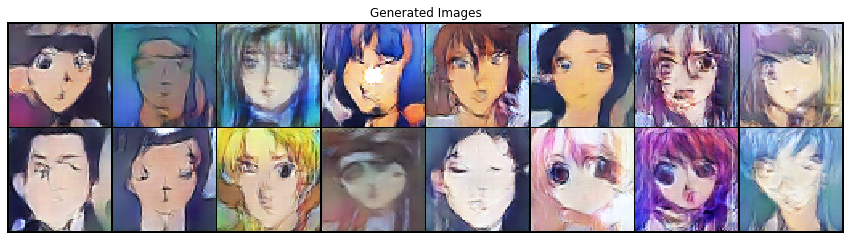

Epoch: (27/51), Batch: (0/276), D_Loss: 2.1313, G_Loss: 7.6254, D(x): 0.9798, G(D(z)): 0.7561 / 0.0006
Epoch: (27/51), Batch: (100/276), D_Loss: 1.4233, G_Loss: 6.6830, D(x): 0.9700, G(D(z)): 0.5731 / 0.0014
Epoch: (27/51), Batch: (200/276), D_Loss: 0.7289, G_Loss: 2.2316, D(x): 0.5719, G(D(z)): 0.0312 / 0.1588
Epoch: (28/51), Batch: (0/276), D_Loss: 0.7393, G_Loss: 3.4231, D(x): 0.8917, G(D(z)): 0.2712 / 0.0397
Epoch: (28/51), Batch: (100/276), D_Loss: 0.4910, G_Loss: 2.5318, D(x): 0.7520, G(D(z)): 0.0435 / 0.0865
Epoch: (28/51), Batch: (200/276), D_Loss: 0.6064, G_Loss: 2.7080, D(x): 0.7920, G(D(z)): 0.1574 / 0.0828
Epoch: (29/51), Batch: (0/276), D_Loss: 0.8979, G_Loss: 4.3753, D(x): 0.9489, G(D(z)): 0.3363 / 0.0168
Epoch: (29/51), Batch: (100/276), D_Loss: 0.5873, G_Loss: 3.4674, D(x): 0.8503, G(D(z)): 0.1648 / 0.0427
Epoch: (29/51), Batch: (200/276), D_Loss: 0.5387, G_Loss: 3.1715, D(x): 0.7050, G(D(z)): 0.0338 / 0.0491
Epoch: (30/51), Batch: (0/276), D_Loss: 1.7582, G_Loss: 4.935

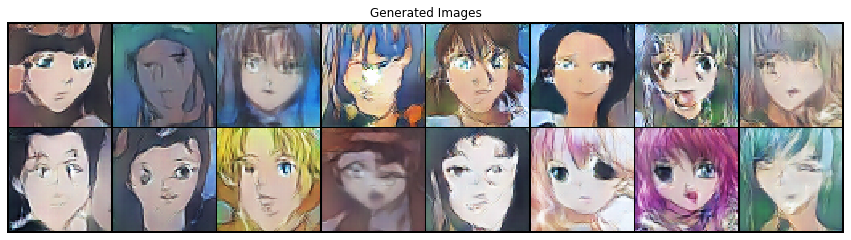

Epoch: (32/51), Batch: (0/276), D_Loss: 0.4997, G_Loss: 2.9581, D(x): 0.7061, G(D(z)): 0.0176 / 0.0648
Epoch: (32/51), Batch: (100/276), D_Loss: 0.5793, G_Loss: 1.8856, D(x): 0.6457, G(D(z)): 0.0270 / 0.1752
Epoch: (32/51), Batch: (200/276), D_Loss: 0.9164, G_Loss: 5.3051, D(x): 0.9549, G(D(z)): 0.3600 / 0.0057
Epoch: (33/51), Batch: (0/276), D_Loss: 0.5819, G_Loss: 3.3653, D(x): 0.8847, G(D(z)): 0.1676 / 0.0424
Epoch: (33/51), Batch: (100/276), D_Loss: 0.4948, G_Loss: 2.9195, D(x): 0.9093, G(D(z)): 0.1175 / 0.0715
Epoch: (33/51), Batch: (200/276), D_Loss: 0.5555, G_Loss: 1.9425, D(x): 0.7200, G(D(z)): 0.0722 / 0.1637
Epoch: (34/51), Batch: (0/276), D_Loss: 0.4440, G_Loss: 3.7150, D(x): 0.8916, G(D(z)): 0.0715 / 0.0318
Epoch: (34/51), Batch: (100/276), D_Loss: 0.5250, G_Loss: 3.0487, D(x): 0.8190, G(D(z)): 0.1225 / 0.0615
Epoch: (34/51), Batch: (200/276), D_Loss: 0.5139, G_Loss: 3.4083, D(x): 0.8909, G(D(z)): 0.1306 / 0.0312
Epoch: (35/51), Batch: (0/276), D_Loss: 0.7712, G_Loss: 2.835

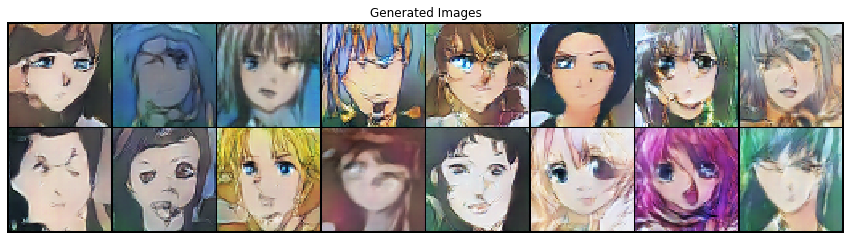

Epoch: (37/51), Batch: (0/276), D_Loss: 1.2185, G_Loss: 5.1953, D(x): 0.9662, G(D(z)): 0.4608 / 0.0063
Epoch: (37/51), Batch: (100/276), D_Loss: 0.4696, G_Loss: 3.6740, D(x): 0.8906, G(D(z)): 0.0965 / 0.0261
Epoch: (37/51), Batch: (200/276), D_Loss: 0.5465, G_Loss: 2.7305, D(x): 0.8759, G(D(z)): 0.1372 / 0.0807
Epoch: (38/51), Batch: (0/276), D_Loss: 0.6224, G_Loss: 4.4014, D(x): 0.8865, G(D(z)): 0.1829 / 0.0160
Epoch: (38/51), Batch: (100/276), D_Loss: 0.7425, G_Loss: 4.6409, D(x): 0.9062, G(D(z)): 0.2759 / 0.0100
Epoch: (38/51), Batch: (200/276), D_Loss: 0.5067, G_Loss: 3.8610, D(x): 0.8725, G(D(z)): 0.1193 / 0.0208
Epoch: (39/51), Batch: (0/276), D_Loss: 0.5137, G_Loss: 4.3415, D(x): 0.9407, G(D(z)): 0.1114 / 0.0149
Epoch: (39/51), Batch: (100/276), D_Loss: 0.4311, G_Loss: 3.7123, D(x): 0.8230, G(D(z)): 0.0395 / 0.0336
Epoch: (39/51), Batch: (200/276), D_Loss: 0.4940, G_Loss: 2.0141, D(x): 0.8392, G(D(z)): 0.0767 / 0.1629
Epoch: (40/51), Batch: (0/276), D_Loss: 0.6663, G_Loss: 1.294

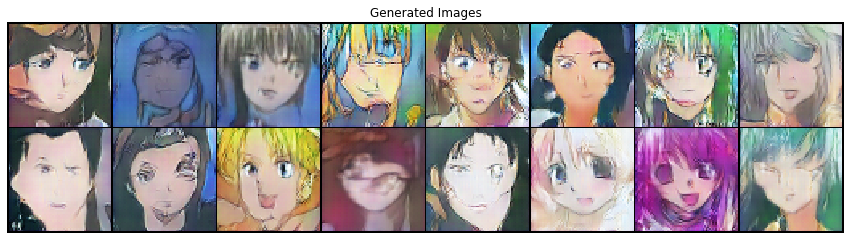

Epoch: (42/51), Batch: (0/276), D_Loss: 1.0602, G_Loss: 5.9008, D(x): 0.9711, G(D(z)): 0.4101 / 0.0027
Epoch: (42/51), Batch: (100/276), D_Loss: 0.4814, G_Loss: 3.5612, D(x): 0.8818, G(D(z)): 0.0793 / 0.0374
Epoch: (42/51), Batch: (200/276), D_Loss: 0.3880, G_Loss: 4.2203, D(x): 0.8800, G(D(z)): 0.0370 / 0.0157
Epoch: (43/51), Batch: (0/276), D_Loss: 0.9483, G_Loss: 3.5220, D(x): 0.7680, G(D(z)): 0.3577 / 0.0307
Epoch: (43/51), Batch: (100/276), D_Loss: 0.4728, G_Loss: 2.9818, D(x): 0.8307, G(D(z)): 0.0811 / 0.0513
Epoch: (43/51), Batch: (200/276), D_Loss: 0.7414, G_Loss: 1.1521, D(x): 0.5506, G(D(z)): 0.0252 / 0.3480
Epoch: (44/51), Batch: (0/276), D_Loss: 0.5531, G_Loss: 4.7920, D(x): 0.8512, G(D(z)): 0.1248 / 0.0109
Epoch: (44/51), Batch: (100/276), D_Loss: 0.4927, G_Loss: 2.0629, D(x): 0.7108, G(D(z)): 0.0195 / 0.1767
Epoch: (44/51), Batch: (200/276), D_Loss: 0.6476, G_Loss: 2.5414, D(x): 0.6495, G(D(z)): 0.0475 / 0.1011
Epoch: (45/51), Batch: (0/276), D_Loss: 0.5767, G_Loss: 1.848

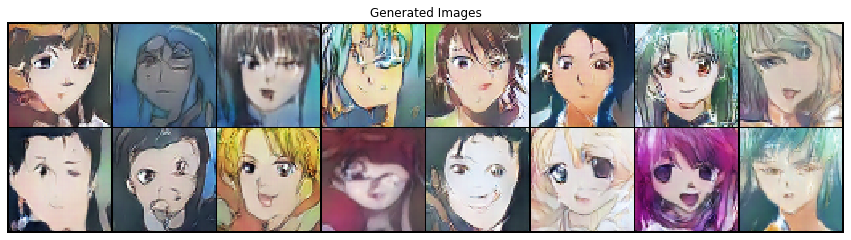

Epoch: (47/51), Batch: (0/276), D_Loss: 0.4144, G_Loss: 4.6234, D(x): 0.8754, G(D(z)): 0.0474 / 0.0094
Epoch: (47/51), Batch: (100/276), D_Loss: 0.4768, G_Loss: 2.8349, D(x): 0.7951, G(D(z)): 0.0529 / 0.0689
Epoch: (47/51), Batch: (200/276), D_Loss: 0.4154, G_Loss: 3.7335, D(x): 0.8158, G(D(z)): 0.0272 / 0.0303
Epoch: (48/51), Batch: (0/276), D_Loss: 1.2078, G_Loss: 4.0524, D(x): 0.9364, G(D(z)): 0.4802 / 0.0205
Epoch: (48/51), Batch: (100/276), D_Loss: 0.4168, G_Loss: 4.3281, D(x): 0.7990, G(D(z)): 0.0171 / 0.0142
Epoch: (48/51), Batch: (200/276), D_Loss: 0.5622, G_Loss: 3.0216, D(x): 0.8411, G(D(z)): 0.1450 / 0.0580
Epoch: (49/51), Batch: (0/276), D_Loss: 3.3984, G_Loss: 8.3228, D(x): 0.9989, G(D(z)): 0.8840 / 0.0003
Epoch: (49/51), Batch: (100/276), D_Loss: 0.4117, G_Loss: 3.1418, D(x): 0.8360, G(D(z)): 0.0331 / 0.0445
Epoch: (49/51), Batch: (200/276), D_Loss: 0.5266, G_Loss: 2.4203, D(x): 0.7464, G(D(z)): 0.0685 / 0.1110
Epoch: (50/51), Batch: (0/276), D_Loss: 0.6041, G_Loss: 2.595

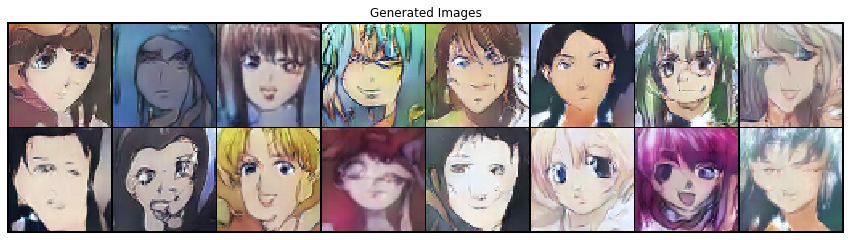

Training Completed!


In [20]:
D = Discriminator().to(device)
G = Generator().to(device)
D.apply(weights_init)
G.apply(weights_init)

if TRAINING_DATA:
    D_optimizer = torch.optim.Adam(D.parameters(), lr = 0.0002, betas= (0.5, 0.999))
    G_optimizer = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))
    error = nn.BCELoss()
    G, D_loss_list, G_loss_list = train(D, G, D_optimizer, G_optimizer, error, dataloader)

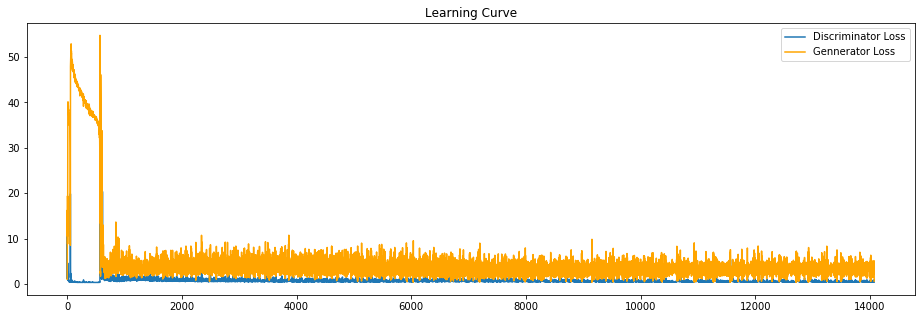

In [21]:
#Plot learning curves
def plot(D_loss_list, G_loss_list, EPOCHS=None):
    if EPOCHS is None:
        EPOCHS = len(D_loss_list)
    fig = plt.figure(figsize=(35,5))
    fig.add_subplot(1,2,1)
    plt.plot(range(EPOCHS), D_loss_list,label = "Discriminator Loss")
    plt.plot(range(EPOCHS),G_loss_list, color ="orange",label = "Gennerator Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()
    
plot(D_loss_list, G_loss_list)

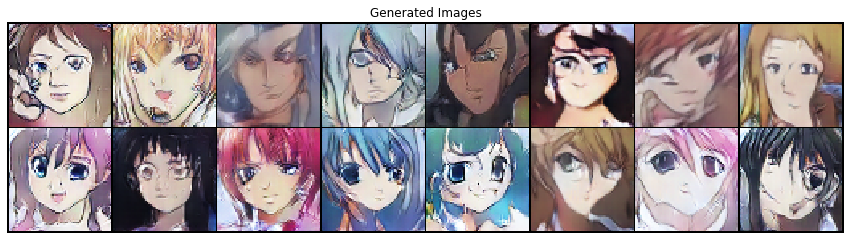

In [42]:
if not TRAINING_DATA:
    G.load_state_dict(torch.load("model/generator.pth"))

#Generate final samples
def visualize_final(NUM_PIC=16):
    test_noise = random_noise(NUM_PIC)
    generate_samples(G, test_noise)
visualize_final()